---
### Universidad de Costa Rica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas
---

- Estudiantes: **Alejandro Zuniga Perez, Natalia Redondo Brenes**
- Carnés: **B59097, B45707**
- Grupo: **1**



## 1. - Primera parte: Determinación teórica del número  s de servidores necesarios para cumplir el requisito.

En el enunciado se mencionan los siguientes aspectos:
- La tasa de llegada $\lambda$ posee un valor de 4 personas por minuta, a la misma vez que es constante durante ocho horas de funcionamiento.

- La tasa de servicio $v$ de cada servidor posee un valor de 0.25 personas por minuto y al igual que la tasa anterior es constante durante ocho horas de funcionamiento. 

Otro aspecto de gran importancia es que en el enunciado se menciona que el sistema no debe exceder la cantidad de 100 personas en la fila durante el 95% del tiempo. Tomando en cuenta cuando se tienen más de 100 personas (en este caso 101), se tiene la siguiente probabilidad:

$$ P(\text{51 o más clientes en el sistema})=\sum_{i=5}^{\infty}(1-\rho)\rho^i$$

Dicho esto, se conoce que $\rho$ es:

$$\rho= \frac{\lambda}{s\cdot v}$$

$$\rho= \frac{4}{s\cdot 0.25}$$

$$\rho= \frac{16}{s}$$

Para que no se excedan las 100 personas el 5% del tiempo se debe cumplir la siguiente inecuación:

$$\sum_{i=5}^{\infty}\left(1-\frac{16}{s}\right) \left(\frac{16}{s}\right)^{i}\leq0.05$$

$$\sum_{i=0}^{50}\left(1-\frac{16}{s}\right)\left(\frac{16}{s}\right)^i\leq0.05$$

Resolviendo la inecuación anterior, en el programa Mathematica (código se muestra a continuación), se obtiene el siguiente resultado:
`Solve[Sum[(1 - 28/s)*(28/s)^i, {i, 0, 100}] == 0.05, s, Reals]`

$$S\geq28.8429 \approx 29$$

Con este resultado, se llega a la conclusión que se ocupan alrededor de 29 servidores para que el sistema funcione correctamente y no se sobrepasen las 100 personas en la fila en el 95% del tiempo.

Para validar el resultado se debe cumplir que $\rho<1$, por lo que:

$$\rho=\frac{28}{28.8429}=0.9708$$

$$0.9708<1$$

Con esto se confirma que el resultado obtenido se cumple dicha condición.

## 2. - Segunda parte: Modificación del código.


Simulación con 29 servidores
Parámetro lambda = 7.0
Parámetro nu = 7.25
Tiempo con más de 100 solicitudes en fila:
	 0.00%
	 Sí cumple con la especificación.
Simulación es equivalente a 9.10 horas.


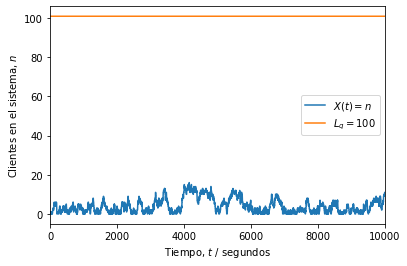

Simulación con 27 servidores
Parámetro lambda = 7.0
Parámetro nu = 6.75
Tiempo con más de 100 solicitudes en fila:
	 17.95%
	 No cumple con la especificación.
Simulación es equivalente a 9.11 horas.


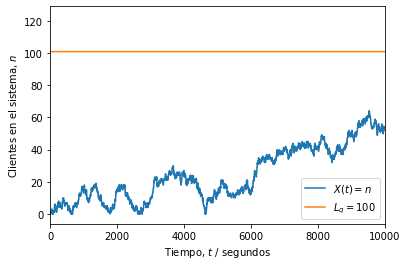

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def simulacion(N, lam, nu):

    # Distribución de los tiempos de llegada entre cada cliente
    X = stats.expon(scale = 1/lam)

    # Distribución de los tiempos de servicio a cada cliente
    Y = stats.expon(scale = 1/nu)

    # Intervalos entre llegadas (segundos desde último cliente)
    t_intervalos = np.ceil(X.rvs(N)).astype('int')

    # Tiempos de las llegadas (segundos desde el inicio)
    t_llegadas = [t_intervalos[0]]
    for i in range(1, len(t_intervalos)):
        siguiente = t_llegadas[i-1] + t_intervalos[i]
        t_llegadas.append(siguiente)

    # Tiempos de servicio (segundos desde inicio de servicio)
    t_servicio = np.ceil(Y.rvs(N)).astype('int')

    # Inicialización del tiempo de inicio y fin de atención
    inicio = t_llegadas[0]          # primera llegada
    fin = inicio + t_servicio[0]    # primera salida

    # Tiempos en que recibe atención cada i-ésimo cliente (!= que llega)
    t_atencion = [inicio]
    for i in range(1, N):
        inicio = np.max((t_llegadas[i], fin))
        fin = inicio + t_servicio[i]
        t_atencion.append(inicio)

    # Inicialización del vector temporal para registrar eventos
    t = np.zeros(t_atencion[-1] + t_servicio[-1] + 1)

    # Asignación de eventos de llegada (+1) y salida (-1) de clientes
    for c in range(N):
        i = t_llegadas[c]
        t[i] += 1
        j = t_atencion[c] + t_servicio[c]
        t[j] -= 1

    # Umbral  de P o más personas en sistema (hay P - 1 en fila)
    P = 102

    # Instantes (segundos) de tiempo con P o más solicitudes en sistema
    exceso = 0

    # Proceso aleatorio (estados n = {0, 1, 2...})
    Xt = np.zeros(t.shape)

    # Inicialización de estado n
    n = 0

    # Recorrido del vector temporal y conteo de clientes (estado n)
    for i, c in enumerate(t):
        n += c # sumar (+1) o restar (-1) al estado
        Xt[i] = n
        if Xt[i] >= P: 
            exceso += 1

    # Fracción de tiempo con P o más solicitudes en sistema
    fraccion = exceso / len(t)

    # Resultados
    print('Parámetro lambda =', str(lam*60))
    print('Parámetro nu =', str(nu*60))
    print('Tiempo con más de {} solicitudes en fila:'.format(P-2))
    print('\t {:0.2f}%'.format(100*fraccion))
    if fraccion <= 0.05:
        print('\t Sí cumple con la especificación.')
    else:
        print('\t No cumple con la especificación.') 
    print('Simulación es equivalente a {:0.2f} horas.'.format(len(t)/3600))

    # Gráfica de X(t) (estados del sistema)
    plt.figure()
    plt.plot(Xt)
    plt.plot(range(len(t)), (P-1)*np.ones(t.shape))
    plt.legend(('$X(t) = n$', '$L_q = $' + str(P-2)))
    plt.ylabel('Clientes en el sistema, $n$')
    plt.xlabel('Tiempo, $t$ / segundos')
    plt.xlim((0, 10000))
    plt.show()

# Definición de parámetros
N = 3500       # Número de clientes
lam = 7/60     # Parámetro de llegada (clientes/segundo)
nu = 0.25/60   # Parámetro de servicio (servicios/segundos)

# Llamado a la simulación
print('Simulación con 29 servidores')
simulacion(N, lam, nu*29)

print('Simulación con 27 servidores')
simulacion(N, lam, nu*27)

---

**Universidad de Costa Rica**

Facultad de Ingeniería

Escuela de Ingeniería Eléctrica

---